In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# English Premier League match outcome prediction
We collected game results and statistics for the 2020-2021 and 2021-2022 season of the English Premier League.  We will do prediction on game outcomes for the 2021 season based on the model trained by data from previous games in 2020 and 2021 seasons.  Random forest is used in this project.  This project is based on the portfolio project from Dataquest.  The data for the 2020 and 2021 seaons have be collected previously via web scraping.

Below are the columns in the data set and description on some of them:
- date: local date
- time: local time in 24-hour format
- comp: competition (all of them are premier league in this table)
- round: round or phase of competition
- day: day of week
- venue: away game or home game
- result: L (loss), W (win) or D (draw)
- gf: goals for
- ga: goals against
- opponent: opposing team
- xg: expected goals provided by Opta (includes penalty kicks but not penalty shoot outs)
- xga: expected goals allowed provided by Opta (includes penalty kicks but not penalty shoot outs)
- poss: possession (% of passes attempted)
- attendance
- captain
- formation: # players in each row from defenders to forward, not including goal keeper
- referee
- sh: shots total (not including penalty kicks)
- sot: shots on target (not including penalty kicks)
- dist: avg distance from shot to goal in yards (not including penalty kicks)
- fk: shots from free kick
- pk: penalty kicks made
- pkatt: penalty kick attempted
- season: 2021 or 2022
- team

In [2]:
df = pd.read_csv('premier_league_stats.csv', index_col=0)
df.columns = df.columns.str.lower()
#df = pd.read_csv('matches.csv', index_col=0)

## Data inspection

In [3]:
df.head(5)

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,NaN,18.0,4.0,17.3,1.0,0,0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,NaN,16.0,4.0,18.5,1.0,0,0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,NaN,25.0,10.0,14.8,0.0,0,0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,NaN,25.0,8.0,14.3,0.0,0,0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,NaN,16.0,1.0,16.4,1.0,0,0,2022,Manchester City


In [4]:
df.shape

(1520, 27)

In [5]:
unique_teams = df['team'].unique()
len(unique_teams)

23

In the English Premier League, 3 teams are promoted and 3 teams are relegated each year.  Each team plays 38 games.  Since the data set has 2 years of data, (38 * 2 * 17 + 38 * 1 * 6) = 1520 rows.  This matches our expectation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 1 to 42
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1520 non-null   object 
 1   time          1520 non-null   object 
 2   comp          1520 non-null   object 
 3   round         1520 non-null   object 
 4   day           1520 non-null   object 
 5   venue         1520 non-null   object 
 6   result        1520 non-null   object 
 7   gf            1520 non-null   int64  
 8   ga            1520 non-null   int64  
 9   opponent      1520 non-null   object 
 10  xg            1520 non-null   float64
 11  xga           1520 non-null   float64
 12  poss          1520 non-null   float64
 13  attendance    824 non-null    float64
 14  captain       1520 non-null   object 
 15  formation     1520 non-null   object 
 16  referee       1520 non-null   object 
 17  match report  1520 non-null   object 
 18  notes         0 non-null      float

## Data analysis and cleaning

Since notes is always empty, the column is removed from the data set

In [7]:
df_clean = df.drop(columns=['notes'])

In [8]:
df_clean.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt',
       'season', 'team'],
      dtype='object')

In [9]:
# Change date to datetime type
df_clean['date'] = pd.to_datetime(df_clean['date'], format='%Y-%m-%d')

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 1 to 42
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1520 non-null   datetime64[ns]
 1   time          1520 non-null   object        
 2   comp          1520 non-null   object        
 3   round         1520 non-null   object        
 4   day           1520 non-null   object        
 5   venue         1520 non-null   object        
 6   result        1520 non-null   object        
 7   gf            1520 non-null   int64         
 8   ga            1520 non-null   int64         
 9   opponent      1520 non-null   object        
 10  xg            1520 non-null   float64       
 11  xga           1520 non-null   float64       
 12  poss          1520 non-null   float64       
 13  attendance    824 non-null    float64       
 14  captain       1520 non-null   object        
 15  formation     1520 non-null   object        


In [11]:
# extract hour from time
df_clean['hour'] = df_clean['time'].str.replace(':.+', '', regex=True).astype('int')
df_clean.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,sh,sot,dist,fk,pk,pkatt,season,team,hour
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,18.0,4.0,17.3,1.0,0,0,2022,Manchester City,16
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,16.0,4.0,18.5,1.0,0,0,2022,Manchester City,15
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,25.0,10.0,14.8,0.0,0,0,2022,Manchester City,12
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,25.0,8.0,14.3,0.0,0,0,2022,Manchester City,15
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,16.0,1.0,16.4,1.0,0,0,2022,Manchester City,15


In [12]:
df_clean['comp'].value_counts()

comp
Premier League    1520
Name: count, dtype: int64

In [13]:
# 'comp' is only 1 value is not useful.  It is removed
df_clean.drop(columns=['comp'], inplace=True)

In [14]:
# add day of week code
df_clean['day_code'] = df_clean['date'].dt.dayofweek

In [15]:
# convert venue to category code
df_clean['venue_code'] = df_clean['venue'].astype('category').cat.codes
# convert opponents to category code
df_clean['op_code'] = df_clean['opponent'].astype('category').cat.codes
df_clean.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,dist,fk,pk,pkatt,season,team,hour,day_code,venue_code,op_code
1,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0,1,Tottenham,1.8,...,17.3,1.0,0,0,2022,Manchester City,16,6,0,18
2,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5,0,Norwich City,2.6,...,18.5,1.0,0,0,2022,Manchester City,15,5,1,15
3,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5,0,Arsenal,4.4,...,14.8,0.0,0,0,2022,Manchester City,12,5,1,0
4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.8,...,14.3,0.0,0,0,2022,Manchester City,15,5,0,10
6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0,0,Southampton,1.0,...,16.4,1.0,0,0,2022,Manchester City,15,5,1,17


There are different ways of handling the non-numerica parameter opponent.  We will use the op_code approach now, and will try using the dummy variables later to see if the accuracy can be improved

In [16]:
df_clean.index.unique().sort_values()

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61],
      dtype='int64')

There are 1520 rows, but the indices range from 0 to 61.  This means that there are duplicates.  We will be using these later to merge tables.  Let us give them unique numbers for each row

In [17]:
df_clean.index = range(df_clean.shape[0])
len(df_clean.index.unique())

1520

In [18]:
# set target to be win or loss the game
df_clean['target'] = (df_clean['result'] == 'W').astype('int')
df_clean.head(3)

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,fk,pk,pkatt,season,team,hour,day_code,venue_code,op_code,target
0,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0,1,Tottenham,1.8,...,1.0,0,0,2022,Manchester City,16,6,0,18,0
1,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5,0,Norwich City,2.6,...,1.0,0,0,2022,Manchester City,15,5,1,15,1
2,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5,0,Arsenal,4.4,...,0.0,0,0,2022,Manchester City,12,5,1,0,1


In [19]:
unique_team_names = df_clean['team'].unique()
unique_opp_names = df_clean['opponent'].unique()
common_names = list(set(unique_team_names).intersection(set(unique_opp_names)))
only_team_names = list(set(unique_team_names) - set(common_names))
only_opp_names = list(set(unique_opp_names) - set(common_names))

print(common_names)
print(only_team_names)
print(only_opp_names)

['Watford', 'Fulham', 'Southampton', 'Crystal Palace', 'Liverpool', 'Everton', 'Chelsea', 'Aston Villa', 'Brentford', 'Arsenal', 'Leicester City', 'Norwich City', 'Leeds United', 'Burnley', 'Manchester City']
['Wolverhampton Wanderers', 'Tottenham Hotspur', 'Brighton and Hove Albion', 'West Ham United', 'Manchester United', 'Sheffield United', 'Newcastle United', 'West Bromwich Albion']
['Tottenham', 'Newcastle Utd', 'Sheffield Utd', 'Brighton', 'Manchester Utd', 'West Brom', 'Wolves', 'West Ham']


In [20]:
# change team names so that they match the opponent names
class MissingDict(dict):
    __missing__ = lambda self, key: key

team_name_mapping = {'Manchester United': 'Manchester Utd',
                     'West Ham United': 'West Ham', 
                     'Brighton and Hove Albion': 'Brighton', 
                     'Tottenham Hotspur': 'Tottenham', 
                     'Newcastle United': 'Newcastle Utd', 
                     'Wolverhampton Wanderers': 'Wolves',
                     'Sheffield United': 'Sheffield Utd',
                     'West Bromwich Albion': 'West Brom'}

mapping = MissingDict(**team_name_mapping)

In [21]:
df_clean['team'] = df_clean['team'].map(mapping)

unique_team_names = df_clean['team'].unique()
unique_opp_names = df_clean['opponent'].unique()
common_names = list(set(unique_team_names).intersection(set(unique_opp_names)))
only_team_names = list(set(unique_team_names) - set(common_names))
only_opp_names = list(set(unique_opp_names) - set(common_names))

print(common_names)
print(only_team_names)
print(only_opp_names)

['Manchester Utd', 'West Brom', 'Newcastle Utd', 'Fulham', 'Brighton', 'Crystal Palace', 'Brentford', 'Leeds United', 'West Ham', 'Watford', 'Liverpool', 'Chelsea', 'Leicester City', 'Norwich City', 'Wolves', 'Burnley', 'Manchester City', 'Tottenham', 'Sheffield Utd', 'Everton', 'Aston Villa', 'Arsenal', 'Southampton']
[]
[]


In [22]:
df_clean['match report'].value_counts()

match report
Match Report    1520
Name: count, dtype: int64

In [23]:
# remove 'match report' since it does not provide any useful information
df_clean.drop(columns=['match report'], inplace=True)
df_clean.columns

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team',
       'hour', 'day_code', 'venue_code', 'op_code', 'target'],
      dtype='object')

In [24]:
df_clean[df_clean['dist'].isnull()]

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,fk,pk,pkatt,season,team,hour,day_code,venue_code,op_code,target
1258,2020-10-18,14:00,Matchweek 5,Sun,Home,D,1,1,Brighton,0.8,...,0.0,1,1,2021,Crystal Palace,14,6,1,3,0


dist is the average shot distance.  It is probably not very useful in our prediction, and will not be included in the features.  If we need to use this later, we will find a way to determine the correct value to use to fill the blank

<Axes: >

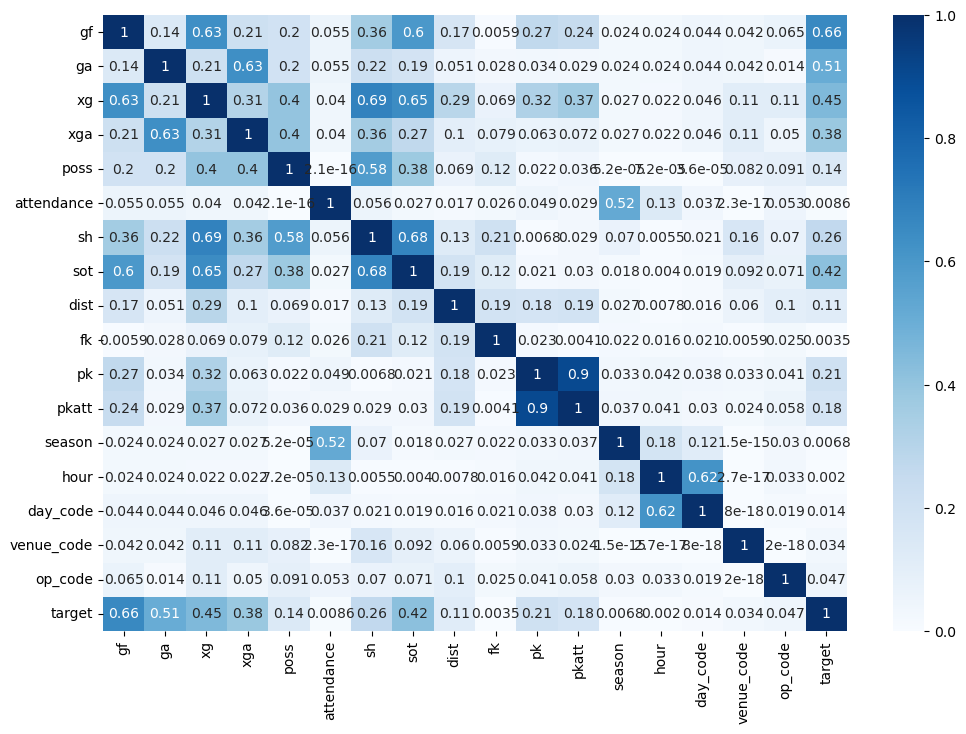

In [25]:
corr = df_clean.drop(columns=['date', 'time']).corr(numeric_only=True)
fig = plt.figure(figsize=(12,8))
sns.heatmap(data=abs(corr), cmap='Blues', annot=True)

The variable 'target' seems most correlated with
- gf: goal for
- ga: goal against
- xg: expected goal
- xga: expected goal against
- sot: shot on target
- sh: shots total
- pk: penalty kicks made

However, all of these variables are unknown at the beginning of the game, so they are not useful in our model.  We can instead create rolling averages on those parameter, such as running average over the previous games played, and see if they help with the prediction

## Create and train model

We will learn the model by using the data from 2020-2021 season and previous games each team played in the 2021-2022 season, and use the model to predict the outcome in the 2021-2022 season

To reduce the complexity, we will create a function that will do the following so that different models can be tried and assessed easily:
- Divide data into training and test sets
- Train the model
- Predict the outcome
- Evaluate performance by comparing the test data

Random forest will be used for evaluation

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

In [27]:
rf = RandomForestClassifier(n_estimators=50,
                            min_samples_split=10,
                            random_state=1)

In [28]:
time_split = '2022-01-01'

def make_prediction(data, predictors):
    train = data[data['date'] < time_split]
    test = data[data['date'] >= time_split]

    X_train = train[predictors]
    y_train = train['target']
    X_test = test[predictors]
    y_test = test['target']
    #print(y_test.index.sort_values())
    #print(len(y_test))
    #print(len(y_test.index.unique()))

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy is {:.2f}%'.format(accuracy*100))

    precision = precision_score(y_test, y_pred)
    print('Precision is {:.2f}%'.format(precision*100))

    test_results = pd.DataFrame({'actual': y_test, 'predict': y_pred})
    #print(len(test_results.index.unique()))
    ct_results = pd.crosstab(test_results['actual'], test_results['predict'])
    print('Crosstab table: \n{}'.format(ct_results))

    return test_results, precision, accuracy

### Reference
We will start with a very basic reference model, where we use only the following predictors: 'venue_code', 'op_code', 'hour', 'day_code'

In [29]:
predictors_ref = ['venue_code', 'op_code', 'hour', 'day_code']
results_ref, precision_ref, accuracy_ref = make_prediction(df_clean, predictors_ref)

Accuracy is 60.66%
Precision is 51.55%
Crosstab table: 
predict    0   1
actual          
0        189  47
1        108  50


Let us create a function to merge the prediction results with information from the original dataset for comparison

In [30]:
len(results_ref.index.unique())

394

In [31]:
# merge data and results based on index
def merge_results_with_data(data, results):
    merged = results.merge(data[['date', 'team', 'opponent', 'result']], how='inner', left_index=True, right_index=True)
    return merged

Next we will create a function where we merge each team's data with its opponents data

In [32]:
def merge_with_opponent(data):
    #print(data.head())
    merged = data.merge(data, left_on=['date', 'team'], right_on=['date', 'opponent'], suffixes=('_team', '_opp'))
    #print(merged.head())

    # remove redundant columns
    redundant_cols = ['time', 'venue', 'day', 'season',
                      'opponent', 'attendance', 
                      'referee', 'team',
                      'hour', 'day_code', 'venue_code', 'op_code', 'target']
    for col in redundant_cols:
        if col+'_team' in merged.columns:
            merged.rename(columns={col+'_team': col}, inplace=True)
            merged.drop(columns=[col+'_opp'], inplace=True)

    return merged

In [33]:
merged_results_ref = merge_results_with_data(df_clean, results_ref)

In [34]:
merged_results_ref = merge_with_opponent(merged_results_ref)
merged_results_ref.head()

,actual_team,predict_team,date,team,opponent,result_team,actual_opp,predict_opp,result_opp
0,1,0,2022-01-01,Manchester City,Arsenal,W,0,0,L
1,1,0,2022-01-15,Manchester City,Chelsea,W,0,0,L
2,0,0,2022-01-22,Manchester City,Southampton,D,0,0,D
3,1,0,2022-02-09,Manchester City,Brentford,W,0,0,L
4,1,1,2022-02-12,Manchester City,Norwich City,W,0,0,L


In [35]:
# Check to see if there is only 1 winning team predicted in each game
merged_results_ref[(merged_results_ref['predict_team'] == 1) & (merged_results_ref['predict_opp'] == 1)]

,actual_team,predict_team,date,team,opponent,result_team,actual_opp,predict_opp,result_opp
138,0,1,2022-02-20,Leicester City,Wolves,L,1,1,W
179,1,1,2022-02-20,Wolves,Leicester City,W,0,1,L
199,1,1,2022-02-26,Newcastle Utd,Brentford,W,0,1,L
208,1,1,2022-04-23,Newcastle Utd,Norwich City,W,0,1,L
229,0,1,2022-05-15,Crystal Palace,Aston Villa,D,0,1,D
240,0,1,2022-02-26,Brentford,Newcastle Utd,L,1,1,W
242,1,1,2022-03-12,Brentford,Burnley,W,0,1,L
249,1,1,2022-05-07,Brentford,Southampton,W,0,1,L
269,0,1,2022-05-15,Aston Villa,Crystal Palace,D,0,1,D
288,0,1,2022-05-07,Southampton,Brentford,L,1,1,W


As shown in the above table, there are cases where more than 1 winner is predicted, which is not possible.  Let us check the precision for games where only 1 winner is predicted

In [36]:
merged_results_ref[(merged_results_ref['predict_team'] == 1) & (merged_results_ref['predict_opp'] == 0)]['actual_team'].value_counts(normalize=True)

actual_team
1    0.530864
0    0.469136
Name: proportion, dtype: float64

In conclusion, for our ref model with predictors \['venue_code', 'op_code', 'hour', 'day_code'\]
- Accuracy = 61%
- Precision = 52%
- Precision with only 1 predicted winner: 53%

## Rolling average for team
Next we will use rolling average of the stats to see if we can improve the model.  We will only make use of the stats from previous games since the current game's stats will not be available until after the game.  We will try averaging 3, 4, or 5 games to see if there is an optimal number of averages

In [37]:
# the following columns are used to calculate running avg
rolling_avg_cols = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
rolling_avg_cols_out = [stat + '_rolling' for stat in rolling_avg_cols]

# define function to calculate rolling avg
def get_rolling_avg(group, cols, new_cols, num_avg):
    group_sorted = group.sort_values('date')
    rolling_mean = group_sorted[cols].rolling(num_avg, closed='left').mean()
    group_sorted[new_cols] = rolling_mean
    # since the beginning rows will not have avg, they will be dropped
    group_sorted.dropna(subset=new_cols, inplace=True)
    return group_sorted

In [38]:
predictors_rolling = predictors_ref + rolling_avg_cols_out
num_avg = range(3, 7)

results_rolling_num_avg = {'accuracy': [], 'precision': [], 'precision_1winner': []}

for rolling_avg_games in num_avg:
    print('*** Number of averages: {} ***'.format(rolling_avg_games))
    df_rolling = df_clean.groupby('team').apply(lambda x: get_rolling_avg(x, rolling_avg_cols, rolling_avg_cols_out, rolling_avg_games))
    #df_rolling.head()
    df_rolling = df_rolling.droplevel('team')
    df_rolling.index = range(df_rolling.shape[0])
    
    results_rolling, precision_rolling, accuracy_rolling = make_prediction(df_rolling, predictors_rolling)
    merged_results_rolling = merge_results_with_data(df_rolling, results_rolling)
    merged_results_rolling = merge_with_opponent(merged_results_rolling)
    pred_1win_count = merged_results_rolling[(merged_results_rolling['predict_team'] == 1) & (merged_results_rolling['predict_opp'] == 0)]['actual_team'].value_counts(normalize=True)
    print('\nFor games with only 1 predicted winnner: \n{}\n'.format(pred_1win_count))

    results_rolling_num_avg['accuracy'].append(accuracy_rolling)
    results_rolling_num_avg['precision'].append(precision_rolling)
    results_rolling_num_avg['precision_1winner'].append(pred_1win_count[1])

*** Number of averages: 3 ***
Accuracy is 60.91%
Precision is 52.13%
Crosstab table: 
predict    0   1
actual          
0        191  45
1        109  49

For games with only 1 predicted winnner: 
actual_team
1    0.536585
0    0.463415
Name: proportion, dtype: float64

*** Number of averages: 4 ***
Accuracy is 65.74%
Precision is 63.53%
Crosstab table: 
predict    0   1
actual          
0        205  31
1        104  54

For games with only 1 predicted winnner: 
actual_team
1    0.653333
0    0.346667
Name: proportion, dtype: float64

*** Number of averages: 5 ***
Accuracy is 65.48%
Precision is 61.46%
Crosstab table: 
predict    0   1
actual          
0        199  37
1         99  59

For games with only 1 predicted winnner: 
actual_team
1    0.684211
0    0.315789
Name: proportion, dtype: float64

*** Number of averages: 6 ***
Accuracy is 64.21%
Precision is 59.14%
Crosstab table: 
predict    0   1
actual          
0        198  38
1        103  55

For games with only 1 predicted 

In [39]:
team_rolling_avg_df = pd.DataFrame(results_rolling_num_avg)
team_rolling_avg_df['num_game_avg'] = num_avg
# rearrange columns
new_cols = ['num_game_avg']
new_cols.extend(team_rolling_avg_df.columns.drop('num_game_avg'))
team_rolling_avg_df = team_rolling_avg_df[new_cols]
team_rolling_avg_df

,num_game_avg,accuracy,precision,precision_1winner
0,3,0.609137,0.521277,0.536585
1,4,0.657360,0.635294,0.653333
2,5,0.654822,0.614583,0.684211
3,6,0.642132,0.591398,0.623377


Using accuracy and precision scores as metric, 4 games is the optimal number of games to average over.  Using precision based on games with 1 predicted winner only, 5 games is the optimal number of games to average over.

## Rolling average for team and opponent
Next we will make use of the avg stats for opponent as well for prediction

Let us run a sample with averaging using previous 3 games and take a look at how the data correlate with the game outcome

In [40]:
df_rolling_5 = df_clean.groupby('team').apply(lambda x: get_rolling_avg(x, rolling_avg_cols, rolling_avg_cols_out, 5))
df_rolling_5 = df_rolling_5.droplevel('team')

df_rolling_opp_5 = merge_with_opponent(df_rolling_5)
df_rolling_opp_5.head()

,date,time,round_team,day,venue,result_team,gf_team,ga_team,opponent,xg_team,...,pk_opp,pkatt_opp,gf_rolling_opp,ga_rolling_opp,sh_rolling_opp,sot_rolling_opp,dist_rolling_opp,fk_rolling_opp,pk_rolling_opp,pkatt_rolling_opp
0,2020-10-25,19:15,Matchweek 6,Sun,Home,L,0,1,Leicester City,0.7,...,0,0,2.4,1.6,8.8,4.0,20.26,0.6,1.0,1.0
1,2020-11-01,16:30,Matchweek 7,Sun,Away,W,1,0,Manchester Utd,1.0,...,0,0,1.8,2.4,13.6,4.4,20.44,0.2,0.4,0.6
2,2020-11-08,19:15,Matchweek 8,Sun,Home,L,0,3,Aston Villa,1.5,...,0,0,2.8,1.8,14.0,6.4,17.00,0.4,0.2,0.2
3,2020-11-22,16:30,Matchweek 9,Sun,Away,D,0,0,Leeds United,0.9,...,0,0,1.2,2.0,14.4,5.0,15.62,0.4,0.0,0.0
4,2020-11-29,19:15,Matchweek 10,Sun,Home,L,1,2,Wolves,1.5,...,0,0,1.0,0.6,13.2,4.4,19.24,0.4,0.0,0.0


<Axes: >

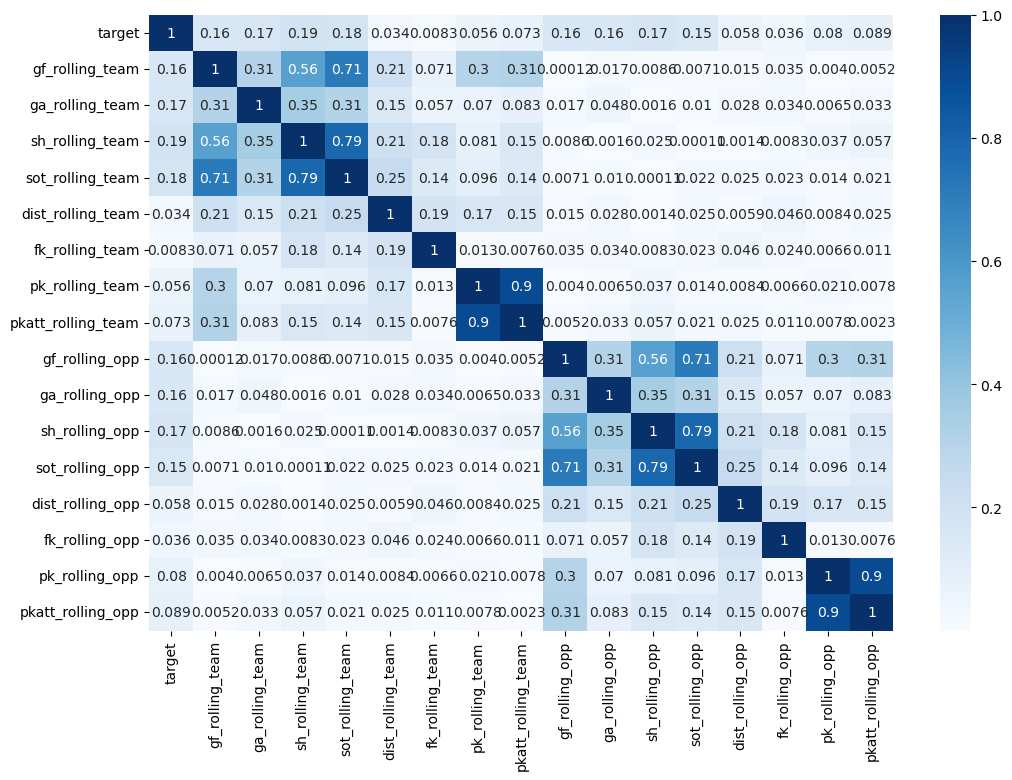

In [41]:
corr_cols = ['target'] + \
    [col+'_team' for col in rolling_avg_cols_out] + \
    [col+'_opp' for col in rolling_avg_cols_out]
rolling_avg_corr = df_rolling_opp_5[corr_cols].corr()
fig = plt.figure(figsize=(12,8))
sns.heatmap(abs(rolling_avg_corr), cmap='Blues', annot=True)

There seems to be high correlation between the target and the previous 5 games rolling average of gf, ga, sh, and sot of both team and opponent

In [42]:
predictors_rolling_opp = predictors_ref + \
    [col+'_team' for col in rolling_avg_cols_out] + \
    [col+'_opp' for col in rolling_avg_cols_out]
num_avg = range(3, 8)

results_rolling_opp_num_avg = {'accuracy': [], 'precision': [], 'precision_1winner': []}

for rolling_avg_games in num_avg:
    print('*** Number of averages: {} ***'.format(rolling_avg_games))
    df_rolling = df_clean.groupby('team').apply(lambda x: get_rolling_avg(x, rolling_avg_cols, rolling_avg_cols_out, rolling_avg_games))
    #df_rolling.head()
    df_rolling = df_rolling.droplevel('team')
    df_rolling.index = range(df_rolling.shape[0])
    
    df_rolling_opp = merge_with_opponent(df_rolling)
    df_rolling_opp.head()
    
    results_rolling_opp, precision_rolling_opp, accuracy_rolling_opp = make_prediction(df_rolling_opp, predictors_rolling_opp)
    merged_results_rolling_opp = merge_results_with_data(df_rolling_opp.rename(columns={'result_team': 'result'}), results_rolling_opp)
    merged_results_rolling_opp = merge_with_opponent(merged_results_rolling_opp)
    pred_1win_count_opp = merged_results_rolling_opp[(merged_results_rolling_opp['predict_team'] == 1) & (merged_results_rolling_opp['predict_opp'] == 0)]['actual_team'].value_counts(normalize=True)
    print('\nFor games with only 1 predicted winnner: \n{}\n'.format(pred_1win_count_opp))

    results_rolling_opp_num_avg['accuracy'].append(accuracy_rolling_opp)
    results_rolling_opp_num_avg['precision'].append(precision_rolling_opp)
    results_rolling_opp_num_avg['precision_1winner'].append(pred_1win_count_opp[1])

*** Number of averages: 3 ***
Accuracy is 63.45%
Precision is 59.21%
Crosstab table: 
predict    0   1
actual          
0        205  31
1        113  45

For games with only 1 predicted winnner: 
actual_team
1    0.592105
0    0.407895
Name: proportion, dtype: float64

*** Number of averages: 4 ***
Accuracy is 63.96%
Precision is 59.09%
Crosstab table: 
predict    0   1
actual          
0        200  36
1        106  52

For games with only 1 predicted winnner: 
actual_team
1    0.593023
0    0.406977
Name: proportion, dtype: float64

*** Number of averages: 5 ***
Accuracy is 63.96%
Precision is 59.09%
Crosstab table: 
predict    0   1
actual          
0        200  36
1        106  52

For games with only 1 predicted winnner: 
actual_team
1    0.590909
0    0.409091
Name: proportion, dtype: float64

*** Number of averages: 6 ***
Accuracy is 66.75%
Precision is 64.84%
Crosstab table: 
predict    0   1
actual          
0        204  32
1         99  59

For games with only 1 predicted 

In [43]:
team_rolling_opp_avg_df = pd.DataFrame(results_rolling_opp_num_avg)
team_rolling_opp_avg_df['num_game_avg'] = num_avg
# rearrange columns
new_cols = ['num_game_avg']
new_cols.extend(team_rolling_opp_avg_df.columns.drop('num_game_avg'))
team_rolling_opp_avg_df = team_rolling_opp_avg_df[new_cols]
team_rolling_opp_avg_df

,num_game_avg,accuracy,precision,precision_1winner
0,3,0.634518,0.592105,0.592105
1,4,0.639594,0.590909,0.593023
2,5,0.639594,0.590909,0.590909
3,6,0.667513,0.648352,0.648352
4,7,0.639594,0.586957,0.586957


Using the opponent's rolling average, we can get accuracy = 67%, precision = 65% and 1-winner precision = 65% using stats from previous 6 games, compared with
using only team's rolling average, where we can get accuracy = 65%, precision = 61% and 1-winner precision = 68% using stats from previous 5 games.  

By using opponent's statistics, we improved the general accuracy and precision, but the 1-winner precision is not as good as using only team's statistics.  This may indicate that we are overfitting the model

## Conclusion
We performed prediction on 2021-2022 season game outcomes based on test data from 2020-2021 season using random forest.  We made use of the rolling average statistics based on the teams and their opponents, as well as the other information such as venue and day of week.  We are able to predict the outcome with 65% for predicted games where there is 1 winner. 